<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tiles3 as tc
from rl_glue import RLGlue
from agent import BaseAgent
from utils import argmax
import mountaincar_env
import time
import random

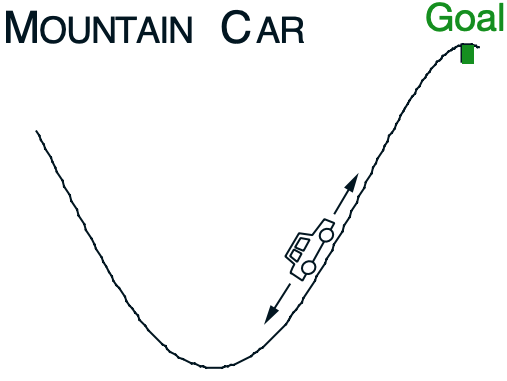

 The car is under-powered so the agent needs to learn to rock back and forth to get enough momentum to reach the goal. At each time step the agent receives from the environment its current velocity (a float between -0.07 and 0.07), and it's current position (a float between -1.2 and 0.5). Because our state is continuous there are a potentially infinite number of states that our agent could be in

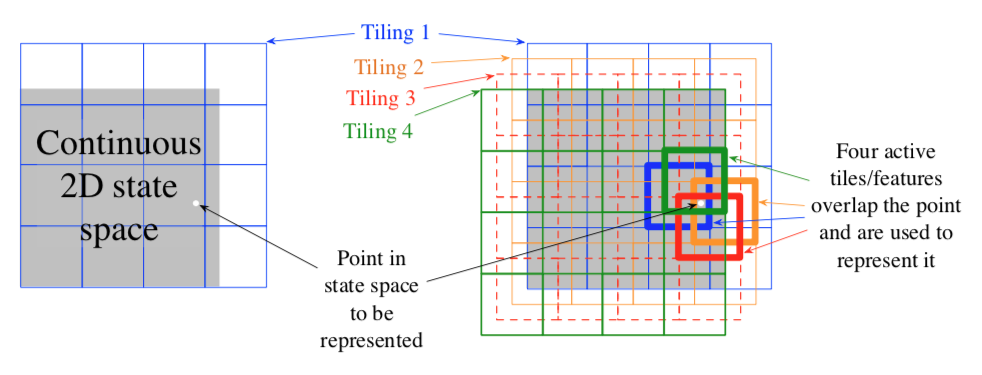

In [ ]:
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles

    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.

        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07

        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)

        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale,
                                                      velocity * velocity_scale])

        return np.array(tiles)


In [ ]:
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)

        self.w = np.ones((self.num_actions,self.iht_size)) * self.initial_weights

        self.tc = MountainCarTileCoder(iht_size = self.iht_size,num_tilings=self.num_tilings,num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values  = []
        chosen_action = None

        action_values = np.zeros(self.num_actions)
        for action in range(self.num_actions):
          action_values[action] = np.sum(self.w[action][tiles])

        if random.random() < self.epsilon:
          chosen_action = self.random.randint(0,self.num_action)
        else:
          chosen_action = argmax(action_values)

        return chosen_action,action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position,velocity = state
        active_tiles = self.tc.get_tiles(position,velocity)
        current_action,action_values = self.select_action(active_tiles)

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        position,velocity = state
        active_tiles = self.tc.get_tiles(position,velocity)
        current_action,action_values = self.select_action(active_tiles)

        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward + self.gamma * action_values - last_action_value) * 1

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward - last_action_value) * 1



RUN: 0
RUN: 5
Run time: 14.193084955215454


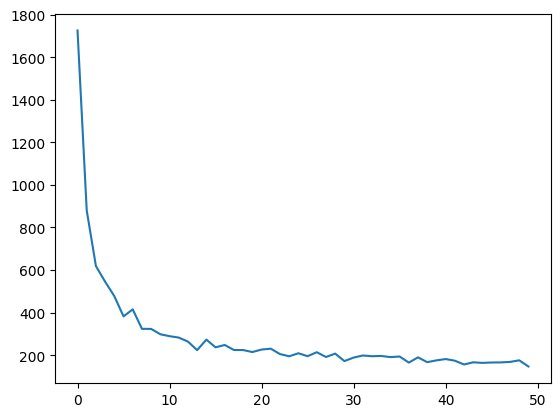

In [ ]:
num_runs = 10
num_episodes = 50
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []

agent = SarsaAgent
env = mountaincar_env.Environment
start = time.time()

for run in range(num_runs):
    if run % 5 == 0:
        print("RUN: {}".format(run))

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    steps_per_episode = []

    for episode in range(num_episodes):
        rl_glue.rl_episode(15000)
        steps_per_episode.append(rl_glue.num_steps)

    all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

plt.plot(np.mean(np.array(all_steps), axis=0))
np.save("sarsa_test", np.array(all_steps))

RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.25
Run Time: 66.8105537891388
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.015625
Run Time: 40.82242465019226
RUN: 0
RUN: 5
RUN: 10
RUN: 15
0.0625
Run Time: 38.658554792404175


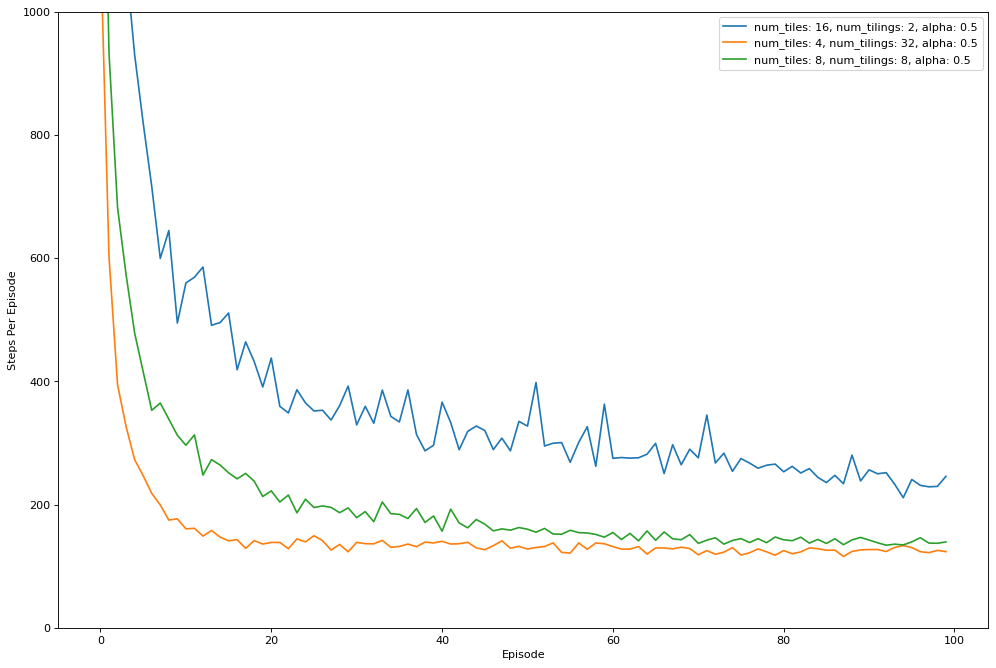

In [ ]:
num_runs = 20
num_episodes = 100
env_info = {}

agent_runs = []
# alphas = [0.2, 0.4, 0.5, 1.0]
alphas = [0.5]
agent_info_options = [{"num_tiles": 16, "num_tilings": 2, "alpha": 0.5},
                      {"num_tiles": 4, "num_tilings": 32, "alpha": 0.5},
                      {"num_tiles": 8, "num_tilings": 8, "alpha": 0.5}]
agent_info_options = [{"num_tiles" : agent["num_tiles"],
                       "num_tilings": agent["num_tilings"],
                       "alpha" : alpha} for agent in agent_info_options for alpha in alphas]

agent = SarsaAgent
env = mountaincar_env.Environment
for agent_info in agent_info_options:
    all_steps = []
    start = time.time()
    for run in range(num_runs):
        if run % 5 == 0:
            print("RUN: {}".format(run))
        env = mountaincar_env.Environment

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)
        all_steps.append(np.array(steps_per_episode))

    agent_runs.append(np.mean(np.array(all_steps), axis=0))
    print(rl_glue.agent.alpha)
    print("Run Time: {}".format(time.time() - start))

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.array(agent_runs).T)
plt.xlabel("Episode")
plt.ylabel("Steps Per Episode")
plt.yscale("linear")
plt.ylim(0, 1000)
plt.legend(["num_tiles: {}, num_tilings: {}, alpha: {}".format(agent_info["num_tiles"],
                                                               agent_info["num_tilings"],
                                                               agent_info["alpha"])
            for agent_info in agent_info_options])

Here we can see that using 32 tilings and 4 x 4 tiles does a little better than 8 tilings with 8x8 tiles. Both seem to do much better than using 2 tilings, with 16 x 16 tiles.